Fraud Detection of Financial Transaction

In [2]:
# Basic libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Metrics for model evaluation
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Deep Learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# For handling imbalanced datasets
from imblearn.over_sampling import SMOTE


In [3]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Describe the data (to see distributions and summary statistics)
print(df.describe())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
#Data Preprocessing 
# Checking the imbalance in the dataset
print(df['Class'].value_counts())

# Separate the features (X) and labels (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
# Handle Imbalanced Data with SMOTE 
# Use SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new balance of classes after resampling
print(pd.Series(y_train_resampled).value_counts())


Class
0    199020
1    199020
Name: count, dtype: int64


In [6]:
# Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Train the model
iso_forest.fit(X_train)

# Predict on the test set (-1 indicates outliers)
y_pred_iso = iso_forest.predict(X_test)

# Convert -1 (outliers) to 1 (fraud) and 1 (inliers) to 0 (non-fraud)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# Evaluate the model
print("Isolation Forest Performance:")
print(classification_report(y_test, y_pred_iso))


Isolation Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.10      0.55      0.16       148

    accuracy                           0.99     85443
   macro avg       0.55      0.77      0.58     85443
weighted avg       1.00      0.99      0.99     85443



In [7]:
# Local Outlier Factor (LOF) model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model on the training data and predict the labels
y_pred_lof = lof.fit_predict(X_test)

# Convert -1 (outliers) to 1 (fraud) and 1 (inliers) to 0 (non-fraud)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

# Evaluate the model
print("Local Outlier Factor Performance:")
print(classification_report(y_test, y_pred_lof))


Local Outlier Factor Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.01      0.05      0.02       148

    accuracy                           0.99     85443
   macro avg       0.50      0.52      0.51     85443
weighted avg       1.00      0.99      0.99     85443



In [8]:
# Build the Autoencoder model
input_dim = X_train.shape[1]  # Number of input features
encoding_dim = 14  # Number of neurons in the bottleneck layer

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(7, activation='relu')(encoded)

# Decoder
decoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=True, validation_split=0.2)

# Get the reconstruction error for the test set
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set a threshold for anomalies
threshold = np.percentile(mse, 99)

# Flag points with high reconstruction error as anomalies
y_pred_autoencoder = np.where(mse > threshold, 1, 0)

# Evaluate the model
print("Autoencoder Performance:")
print(classification_report(y_test, y_pred_autoencoder))


Epoch 1/10
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 108s 43ms/step - loss: 0.8369 - val_loss: 0.8428
Epoch 5/10
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step - loss: 0.8319 - val_loss: 0.8382
Epoch 6/10
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 103s 22ms/step - loss: 0.8424 - val_loss: 0.8345
Epoch 7/10
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 0.8256 - val_loss: 0.8325
Epoch 8/10
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 97s 27ms/step - loss: 0.8194 - val_loss: 0.8305
Epoch 9/10
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 84s 34ms/step - loss: 0.8225 - val_loss: 0.8268
Epoch 10/10
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 137s 31ms/step - loss: 0.8157 - val_loss: 0.8261
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 71s 26ms/step
Autoencoder Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.10      0.59      0.17       148

    accuracy                           0.99     85443
   macro avg       0.55      0.79      0.58     85443
weighted avg       1.00 

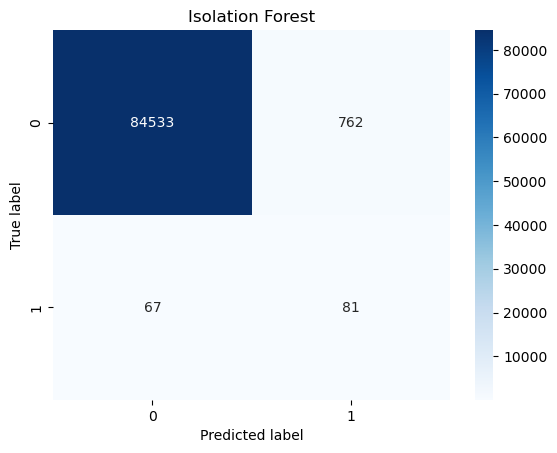

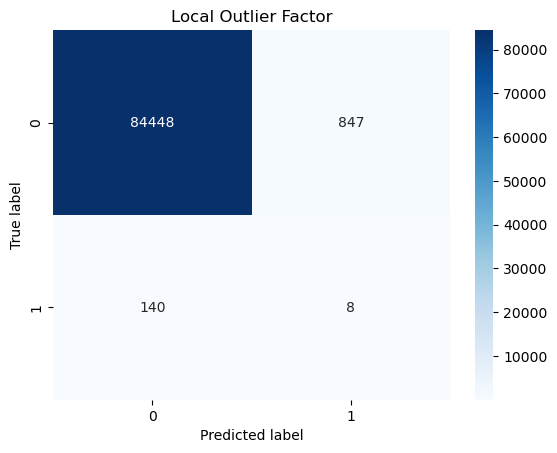

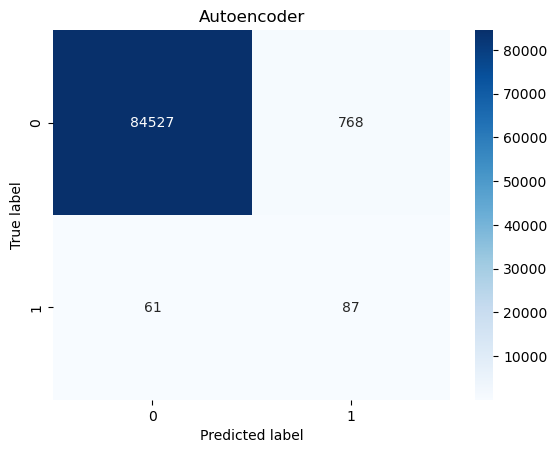

In [9]:
# Confusion matrix for each model
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_iso, "Isolation Forest")
plot_confusion_matrix(y_test, y_pred_lof, "Local Outlier Factor")
plot_confusion_matrix(y_test, y_pred_autoencoder, "Autoencoder")
